In [ ]:
# Source : https://github.com/AksharGoyal/cat-and-dog-image-classifier/blob/main/Akshar_fcc_cat_dog.ipynb

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dog

In [ ]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [ ]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# 1) ImageDataGenerator objects – one per split
# ---------------------------------------------------------------
# ▸ We only rescale (0-255 → 0-1); no augmentation in this snippet.
train_gen      = ImageDataGenerator(rescale=1/255)
valid_gen      = ImageDataGenerator(rescale=1/255)
test_gen       = ImageDataGenerator(rescale=1/255)

# 2) Directory iterators – create an endless stream of batches
# ---------------------------------------------------------------
# TRAINING — returns (images, labels) with binary labels (0/1)
train_data_gen = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'  # → maps sub-folder names to 0/1
)

# VALIDATION — used during training to monitor generalization
val_data_gen = valid_gen.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# TEST / PREDICTION — no labels available
# We point to PATH and restrict Keras to the single “test” folder.
# class_mode='input' returns only the images (x, x) so predict() works.
test_data_gen = test_gen.flow_from_directory(
    directory=PATH,
    classes=['test'],            # look only in PATH/test
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='input',          # images in, images out (no labels)
    shuffle=False                # preserve filename order
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Sequence, Union, Optional

def plot_images(
    images:   Sequence[np.ndarray],
    probs:    Union[Sequence[float], np.ndarray, float, None] = None,
    ncols:    int = 5,
    class_names: tuple[str, str] = ("Cat", "Dog"),
    save_path: Optional[str] = None,
) -> None:
    images = np.asarray(images)
    nimgs  = len(images)
    ncols  = max(1, ncols)
    nrows  = int(np.ceil(nimgs / ncols))

    # Make probs a 1-D array or None
    if probs is None:
        probs_arr = None
    else:
        probs_arr = np.atleast_1d(np.asarray(probs, dtype=float))
        if probs_arr.size == 1:
            probs_arr = np.full(nimgs, probs_arr.item())

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols * 3, nrows * 3),
                             squeeze=False)

    for idx, (img, ax) in enumerate(zip(images, axes.flat)):
        # Matplotlib expects float32 in [0,1] or uint8 in [0,255]
        if img.dtype == np.float32 or img.dtype == np.float64:
            img_disp = np.clip(img, 0, 1)
        else:
            img_disp = img
        ax.imshow(img_disp)
        ax.axis("off")

        if probs_arr is not None and idx < len(probs_arr):
            p = float(probs_arr[idx])
            label = class_names[1] if p > 0.5 else class_names[0]
            conf  = p if p > 0.5 else 1 - p
            ax.set_title(f"{label} ({conf*100:.1f} %)", fontsize=10)

    # Hide any empty sub-plots
    for ax in axes.flat[nimgs:]:
        ax.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

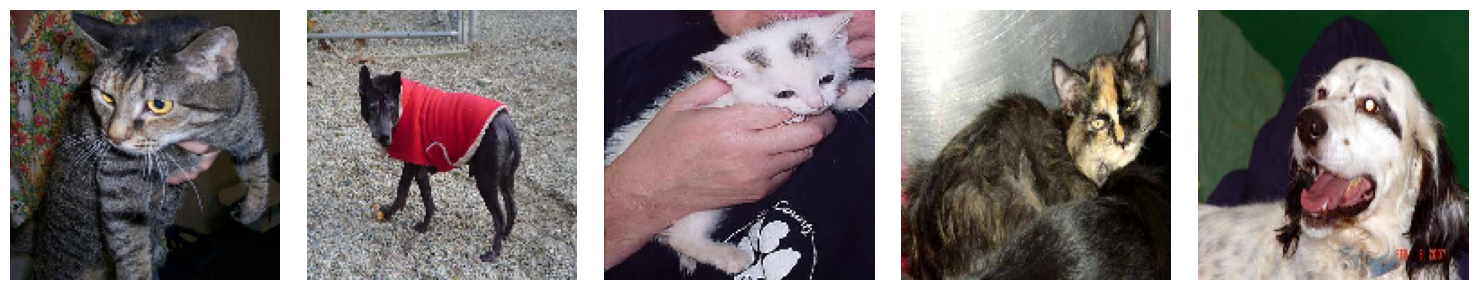

In [ ]:
# show 5 random training images, no titles
sample_imgs, _ = next(train_data_gen)
plot_images(sample_imgs[:5], ncols=5)

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255,        # scale raw pixels to [0, 1]
    # ─ Spatial transforms ──────────────────────────────────────────
    rotation_range=15,        # random rotation ±15°
    width_shift_range=0.10,   # horizontal shift up to ±10 %
    height_shift_range=0.10,  # vertical   shift up to ±10 %
    shear_range=0.10,         # shear transform up to ±10°
    zoom_range=0.10,          # zoom in/out  up to ±10 %
    # ─ Flips ───────────────────────────────────────────────────────
    horizontal_flip=True,     # good for left/right symmetry
    # vertical_flip=False,    # *disabled*: upside-down pets look unnatural
    # ─ Filling strategy ───────────────────────────────────────────
    fill_mode="nearest"       # new pixels (after shifts/rotations) copy nearest
)

Found 2000 images belonging to 2 classes.


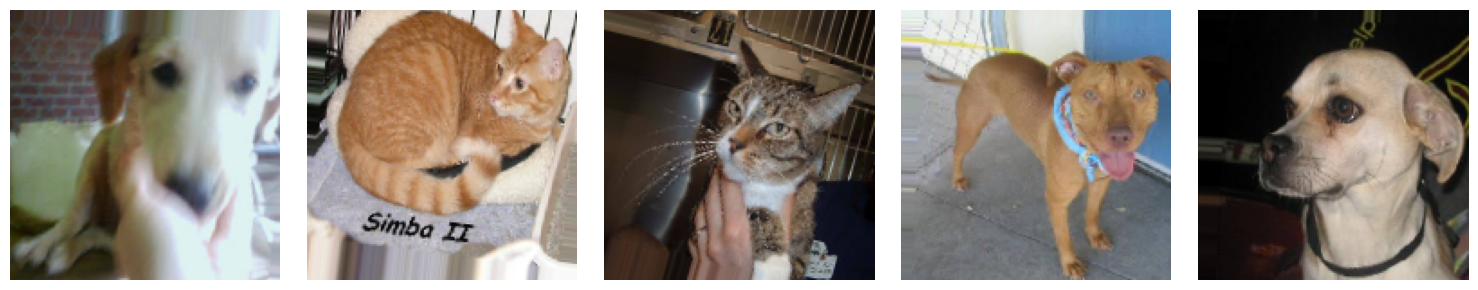

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,             # root folder with class sub-dirs
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

images_batch, labels_batch = next(train_data_gen)
n_preview = 5   # <= set to any number ≤ batch_size
plot_images(images_batch[:n_preview])

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
total_train//batch_size, total_val//batch_size, total_train, total_val, batch_size

(15, 7, 2001, 1001, 128)

In [ ]:
history = model.fit(train_data_gen, steps_per_epoch=total_train//batch_size, epochs=epochs,
                    validation_data=val_data_gen, validation_steps=total_val//batch_size, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5035 - loss: 1.1769

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.5044 - loss: 1.1604 - val_accuracy: 0.5078 - val_loss: 0.7048
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4844 - loss: 0.7209

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.4844 - loss: 0.7209 - val_accuracy: 0.5078 - val_loss: 0.6914
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.5208 - loss: 0.6922 - val_accuracy: 0.6295 - val_loss: 0.6738
Epoch 4/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7031 - loss: 0.6758

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7031 - loss: 0.6758 - val_accuracy: 0.6004 - val_loss: 0.6701
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.5939 - loss: 0.6678 - val_accuracy: 0.6228 - val_loss: 0.6387
Epoch 6/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6484 - loss: 0.6495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6484 - loss: 0.6495 - val_accuracy: 0.6585 - val_loss: 0.6203
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.6186 - loss: 0.6488 - val_accuracy: 0.6574 - val_loss: 0.6263
Epoch 8/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7500 - loss: 0.5821

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7500 - loss: 0.5821 - val_accuracy: 0.6473 - val_loss: 0.6263
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6875 - loss: 0.6047 - val_accuracy: 0.6730 - val_loss: 0.6087
Epoch 10/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7109 - loss: 0.5690

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - accuracy: 0.7109 - loss: 0.5690 - val_accuracy: 0.6853 - val_loss: 0.5930
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.6833 - loss: 0.5956 - val_accuracy: 0.6150 - val_loss: 0.6393
Epoch 12/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6328 - loss: 0.6176

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 571ms/step - accuracy: 0.6328 - loss: 0.6176 - val_accuracy: 0.6696 - val_loss: 0.6023
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.6906 - loss: 0.5845 - val_accuracy: 0.6808 - val_loss: 0.6006
Epoch 14/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7422 - loss: 0.5784

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 575ms/step - accuracy: 0.7422 - loss: 0.5784 - val_accuracy: 0.6808 - val_loss: 0.5951
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.7049 - loss: 0.5560 - val_accuracy: 0.6518 - val_loss: 0.6244
Epoch 16/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7031 - loss: 0.5774

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7031 - loss: 0.5774 - val_accuracy: 0.6786 - val_loss: 0.5997
Epoch 17/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7309 - loss: 0.5415 - val_accuracy: 0.7065 - val_loss: 0.5620
Epoch 18/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7500 - loss: 0.5162

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.7500 - loss: 0.5162 - val_accuracy: 0.7065 - val_loss: 0.5676
Epoch 19/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.7322 - loss: 0.5306 - val_accuracy: 0.7132 - val_loss: 0.5412
Epoch 20/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7344 - loss: 0.5328

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.7344 - loss: 0.5328 - val_accuracy: 0.7098 - val_loss: 0.5443


[한국어]

1. CNN 모델 구성
: Sequential로 두 개의 Conv-Pool 블록 → Flatten → Dense(128) → Dense(1, sigmoid) 아키텍처를 만들고, Adam(learning_rate=0.001) + binary_crossentropy로 컴파일했습니다.

2. 데이터 파이프라인 : ImageDataGenerator를 활용해 학습용(train), 검증용(val), 테스트용(test) 제너레이터를 만들고, 학습 쪽에는 적절한 확대·이동·플립 등 데이터 증강을 적용했습니다.

3. 시각화 유틸리티 : 배치에서 뽑은 이미지를 확인하는 plot_images(또는 plotImages) 함수를 개선해, 확률(예측값)을 함께 표기할 수 있도록 만들었습니다.

4. 예측/디버깅 : classifier.predict(...)로 확률을 구해 시각화했고, 변수명(model vs classifier) 불일치로 생긴 NameError를 해결했습니다.

5. 증강 미리보기 : next(train_data_gen)으로 실제 학습 시 들어가는 증강 이미지를 확인했습니다.

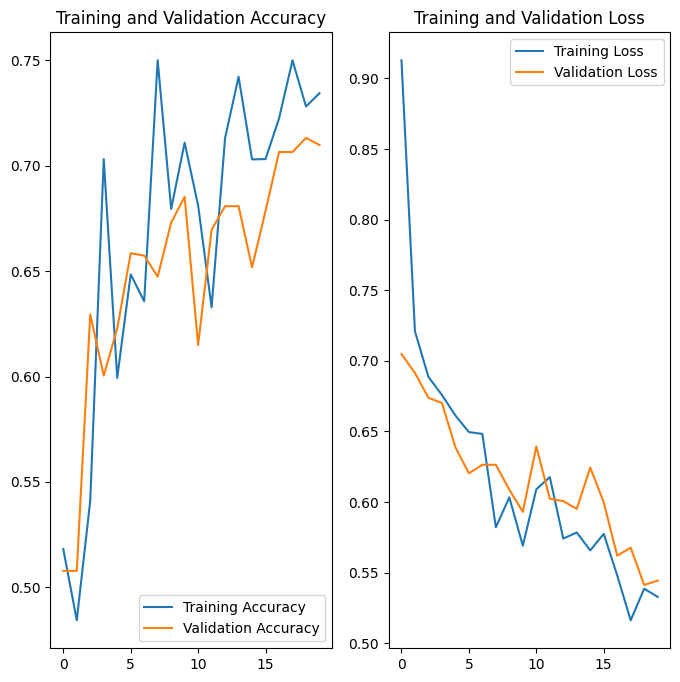

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_images, _ = next(test_data_gen)

# Predict probabilities for that same batch
probs = classifier.predict(test_images, verbose=0).ravel()   # 1-D array

# Visualize
plot_images(test_images, probs, ncols=5)

NameError: name 'classifier' is not defined

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")